In [1]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
from coin_if import COINWrapper,read_COIN_params

In [3]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace
from stat_utils import bic

In [4]:
#setting torch seeds
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True


In [5]:
# from coin_if import read_COIN_params
# raw_coin_params = read_COIN_params('/fitted_parameters/')

In [6]:
args = SimpleNamespace()
args.paradigm = ['evoked', 'spontaneous']

paradigm_short = {
    'evoked': 'E',
    'spontaneous': 'S'
}

paradigm_info = {
    'evoked': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous': {
        'i_min': 1,
        'i_max': 8,}
    }



In [7]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
# param_names = [k for k in raw_coin_params['E1'].keys()]

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_recovery_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

In [93]:
ch_data = { k: d[-100:] for k,d in data.items()}
ch_data_x = {k: np.arange(len(d))[-100:] for k,d in data.items()}

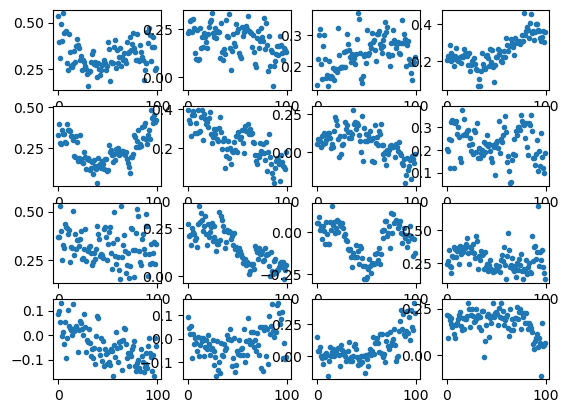

In [9]:
for k in ch_data:
    plt.subplot(4,4,k+1)
    plt.plot(ch_data[k],'.')

In [10]:
def decay_model(tmax, y0, yfinal, tau, alpha):
    y = [y0]
    for t in range(1, tmax):
        y.append(y[-1] + 1/tau * np.sign(yfinal - y[-1]) * np.abs(yfinal - y[-1]) ** alpha)
    return np.array(y)

In [11]:
# local optimisation of parameters with fixed seed=0
# define objective function
def objective_fun_wrapper(target):
    def loss_fun(x):
        out = decay_model(len(target), x[0], x[1], x[2], x[3])
        mse = np.nanmean((out - target) ** 2)
        return mse
    return loss_fun


In [12]:
#import local optimization method
from scipy.optimize import minimize



In [13]:
opt_params = {}
for k in ch_data:
    # print(f'Optimizing parameters for {k} with initial params {opt_data[k][pooling_fun]["x"]}')
    y0 = np.mean(ch_data[k][:10])
    yfinal = np.mean(ch_data[k][-10:])
    opt_params[k] = minimize(objective_fun_wrapper(ch_data[k]),
                        [y0,yfinal,5,1],
                        method='Nelder-Mead',
                        options={'maxiter': 1000, 'disp': True})
    print(f'Optimized parameters for {k}: {opt_params[k].x}')

Optimization terminated successfully.
         Current function value: 0.004606
         Iterations: 232
         Function evaluations: 381
Optimized parameters for 0: [ 0.4768494   0.30928634 22.91627174  0.60695581]


/tmp/ipykernel_3146471/3959998421.py:4: RuntimeWarning: overflow encountered in double_scalars
  y.append(y[-1] + 1/tau * np.sign(yfinal - y[-1]) * np.abs(yfinal - y[-1]) ** alpha)
/tmp/ipykernel_3146471/3477495634.py:6: RuntimeWarning: overflow encountered in square
  mse = np.nanmean((out - target) ** 2)
/tmp/ipykernel_3146471/1970576682.py:6: RuntimeWarning: Maximum number of iterations has been exceeded.
  opt_params[k] = minimize(objective_fun_wrapper(ch_data[k]),


Optimized parameters for 1: [ 2.24661053e-01 -7.48135605e-01  3.99302142e+03 -2.00339122e+01]
Optimization terminated successfully.
         Current function value: 0.002377
         Iterations: 630
         Function evaluations: 1038
Optimized parameters for 2: [1.97414130e-01 2.61858319e-01 8.97890645e+02 9.84687759e-03]
Optimized parameters for 3: [  0.17364868   1.42202305 129.13846458  -8.78228679]
Optimization terminated successfully.
         Current function value: 0.007638
         Iterations: 589
         Function evaluations: 964
Optimized parameters for 4: [3.61206645e-01 2.31325888e-01 1.92687408e+02 1.30723783e-02]
Optimization terminated successfully.
         Current function value: 0.003257
         Iterations: 858
         Function evaluations: 1416
Optimized parameters for 5: [ 3.43001319e-01  7.83187766e-02  6.25513884e+02 -2.03991352e-01]
Optimized parameters for 6: [ 1.29231503e-01 -1.01872917e+00  2.27571883e+02 -1.16156143e+01]
Optimized parameters for 7: [ 0.25

In [14]:
fits = {k: decay_model(len(ch_data[k]), opt_params[k].x[0], opt_params[k].x[1], opt_params[k].x[2], opt_params[k].x[3]) for k in ch_data}

In [84]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
symbols = ['+','x']

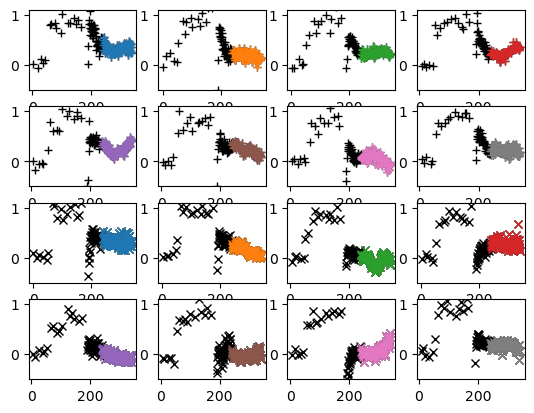

In [101]:
for k in ch_data:
    plt.subplot(4,4,k+1)
    plt.plot(data[k],symbols[k//8],color='black', label='data')
    plt.plot(ch_data_x[k],ch_data[k],symbols[k//8],color=colors[k%8], label='data')
    # plt.plot(fits[k],'--b', label='fit')
    # plt.title(f'ID {k}')
    plt.ylim([-0.5,1.1])

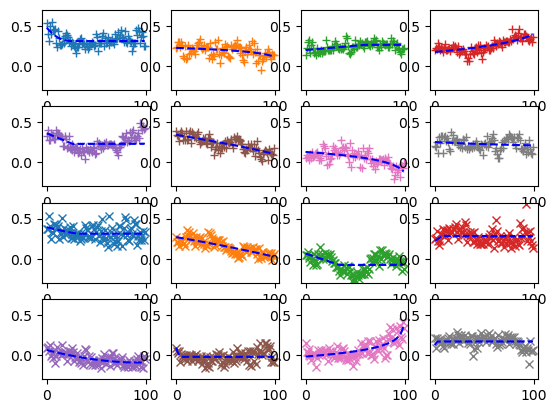

In [85]:
for k in ch_data:
    plt.subplot(4,4,k+1)
    plt.plot(ch_data[k],symbols[k//8],color=colors[k%8], label='data')
    plt.plot(fits[k],'--b', label='fit')
    # plt.title(f'ID {k}')
    plt.ylim([-0.3,0.7])

    # plt.legend()

In [17]:
centered_ch_data = {k: ch_data[k] - fits[k] for k in ch_data}

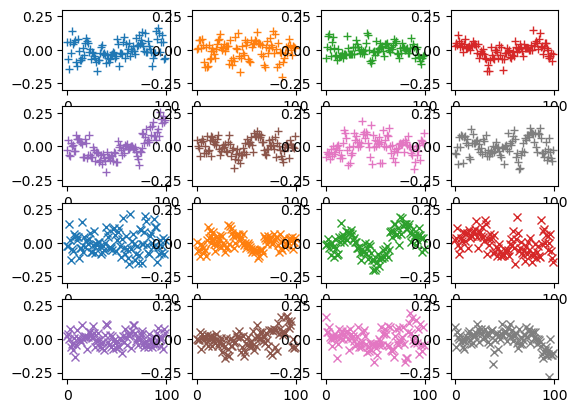

In [89]:
# for k in centered_ch_data:
#     plt.subplot(4,4,k+1)
#     plt.plot(centered_ch_data[k],'.', label='data')
#     plt.title(f'ID {k}')

for k in ch_data:
    plt.subplot(4,4,k+1)
    plt.plot(centered_ch_data[k],symbols[k//8],color=colors[k%8], label='data')
    # plt.title(f'ID {k}')
    plt.ylim([-0.3,0.3])

In [19]:
#compute autocorrelation for all the centered data
def autocorr(x,dim=0):
    if dim != 0:
        x = np.swapaxes(x, 0, dim)
    autocorr_values = []
    for lag in range(0, np.shape(x)[0]):
        autocorr_values.append(np.corrcoef(x[:-lag].reshape(-1), x[lag:].reshape(-1))[0, 1])
    return np.array(autocorr_values)



In [20]:
autocorrs = {k: autocorr(centered_ch_data[k]) for k in centered_ch_data}

/scratch/ar2342/miconda3/envs/py_frogs/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/scratch/ar2342/miconda3/envs/py_frogs/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/scratch/ar2342/miconda3/envs/py_frogs/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


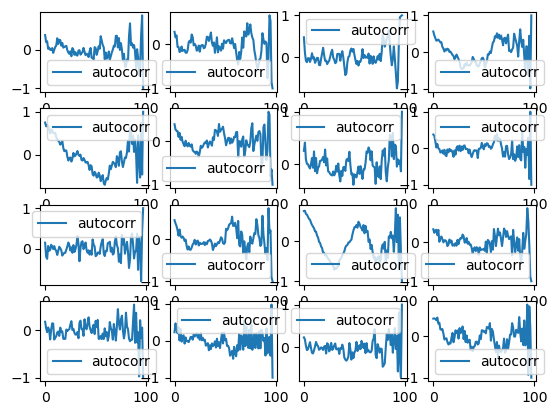

In [21]:
for k in ch_data:
    plt.subplot(4,4,k+1)
    plt.plot(autocorrs[k], label='autocorr')
    plt.legend()

In [22]:
ch_data_np = np.array([centered_ch_data[k] for k in ch_data])

autocorrs_all = autocorr(ch_data_np.T, dim=0)

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

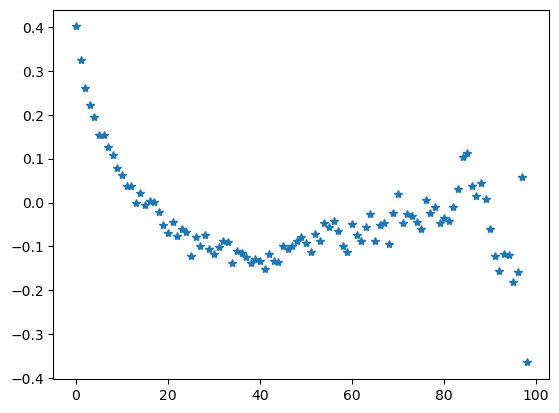

In [23]:
plt.plot(autocorrs_all,'*', label='autocorr all')
plt.legend

In [24]:
#padding with preciding zero for further diff calculations
centered_ch_data_padded = {k: np.concatenate([[0], centered_ch_data[k]]) for k in centered_ch_data}

In [25]:
bics = []
for k in ch_data:
    this_bic = bic(centered_ch_data[k], np.zeros_like(centered_ch_data[k]), 0)
    print(f'BIC for {k}: {this_bic}')
    bics.append(this_bic)


BIC for 0: -538.0444221492666
BIC for 1: -533.3226927689147
BIC for 2: -604.1982541935748
BIC for 3: -585.9386983872719
BIC for 4: -487.46247015960995
BIC for 5: -572.6909094368541
BIC for 6: -531.8363149216898
BIC for 7: -530.7642095953223
BIC for 8: -499.0507468597577
BIC for 9: -591.9857873042773
BIC for 10: -482.26429326582104
BIC for 11: -487.5963445521753
BIC for 12: -593.8337436284505
BIC for 13: -544.4320558351346
BIC for 14: -521.1690073455849
BIC for 15: -541.1088927643822


In [40]:
diffs_centered_ch_data = {k: np.diff(centered_ch_data_padded[k]) for k in centered_ch_data_padded}

diffsA_centered_ch_data = {k: centered_ch_data_padded[k][1:] - 0.4*centered_ch_data_padded[k][:-1] for k in centered_ch_data_padded}

In [41]:
for k in ch_data:
    print(f'BIC for diffs {k}: {bic(diffs_centered_ch_data[k], diffs_centered_ch_data[k]*0, 0)}')

BIC for diffs 0: -516.7854151541139
BIC for diffs 1: -496.77228686334496
BIC for diffs 2: -599.0940215298256
BIC for diffs 3: -598.398315418706
BIC for diffs 4: -558.3602372332972
BIC for diffs 5: -552.7611418596993
BIC for diffs 6: -492.87920463838407
BIC for diffs 7: -507.9755410398336
BIC for diffs 8: -445.39390487526447
BIC for diffs 9: -581.5945600398716
BIC for diffs 10: -548.2576905644136
BIC for diffs 11: -458.57297284610684
BIC for diffs 12: -543.7047880427345
BIC for diffs 13: -501.9043765568641
BIC for diffs 14: -477.8348463613151
BIC for diffs 15: -526.5786032691115


In [42]:
diffsA_bics = []
for k in ch_data:
    this_bic = bic(diffsA_centered_ch_data[k], diffs_centered_ch_data[k]*0, 0)
    print(f'BIC for diffsA {k}: {this_bic}')
    diffsA_bics.append(this_bic)

BIC for diffsA 0: -553.5381842306244
BIC for diffsA 1: -539.8705801659002
BIC for diffsA 2: -628.7667391385719
BIC for diffsA 3: -619.611224408763
BIC for diffsA 4: -543.9199217428688
BIC for diffsA 5: -588.6747163620361
BIC for diffsA 6: -536.411222451571
BIC for diffsA 7: -545.5357018885213
BIC for diffsA 8: -494.7211150342189
BIC for diffsA 9: -613.7086816327093
BIC for diffsA 10: -538.915325430754
BIC for diffsA 11: -497.9731409328148
BIC for diffsA 12: -591.618909455478
BIC for diffsA 13: -547.0524321303017
BIC for diffsA 14: -523.4224081813281
BIC for diffsA 15: -559.9064938929433


Text(0, 0.5, 'BIC for diffsA centered data')

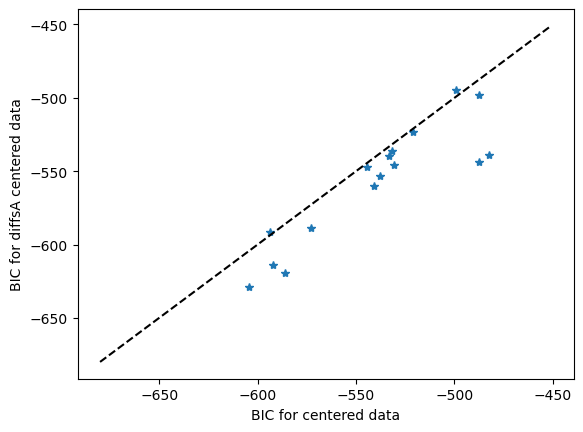

In [44]:
plt.plot(bics, diffsA_bics, '*')
plt.plot(np.arange(-680, -450), np.arange(-680, -450), 'k--')
plt.xlabel('BIC for centered data')
plt.ylabel('BIC for diffsA centered data')

In [45]:
# opt_bics = []
# for k in centered_ch_data:
#     opt_pt = (0,0)
#     for a in np.arange(0, 1, 0.05):
#         diffsOp_centered_ch_data = {k: centered_ch_data_padded[k][1:] - a*centered_ch_data_padded[k][:-1] for k in centered_ch_data_padded}
#         this_bic = bic(diffsOp_centered_ch_data[k], diffsOp_centered_ch_data[k]*0, 1)
#         if this_bic < opt_pt[1]:
#             opt_pt = (a, this_bic)
#     print(f'Optimal a for {k}: {opt_pt[0]} with BIC {opt_pt[1]}')
#     opt_bics.append(opt_pt[1])

# refactor into a function
def compute_optimalOU_bic(padded_data, a_range=np.arange(0, 1, 0.05),k_params=1):
    opt_bics = []
    for k in padded_data:
        opt_pt = (0, 0)
        for a in a_range:
            d = padded_data[k][1:] - a * padded_data[k][:-1]
            this_bic = bic(d, np.zeros_like(d) , k_params)
            if this_bic < opt_pt[1]:
                opt_pt = (a, this_bic)
        print(f'Optimal a for {k}: {opt_pt[0]} with BIC {opt_pt[1]}')
        opt_bics.append(opt_pt[1])
    return opt_bics

In [46]:
opt_bics = compute_optimalOU_bic(centered_ch_data_padded)

Optimal a for 0: 0.4 with BIC -548.9330140446364
Optimal a for 1: 0.30000000000000004 with BIC -536.7865389714384
Optimal a for 2: 0.45 with BIC -624.7827275474264
Optimal a for 3: 0.55 with BIC -618.575767808892
Optimal a for 4: 0.75 with BIC -564.7771778212069
Optimal a for 5: 0.4 with BIC -584.069546176048
Optimal a for 6: 0.25 with BIC -533.9207880074596
Optimal a for 7: 0.35000000000000003 with BIC -540.9667934554055
Optimal a for 8: 0.15000000000000002 with BIC -496.55534197799886
Optimal a for 9: 0.45 with BIC -609.3517647165061
Optimal a for 10: 0.75 with BIC -557.3436686694696
Optimal a for 11: 0.35000000000000003 with BIC -493.8893829285015
Optimal a for 12: 0.15000000000000002 with BIC -592.1488485752062
Optimal a for 13: 0.25 with BIC -545.3075331479146
Optimal a for 14: 0.25 with BIC -521.8309470325776
Optimal a for 15: 0.4 with BIC -555.3013237069553


Text(0, 0.5, 'BIC for opt centered data')

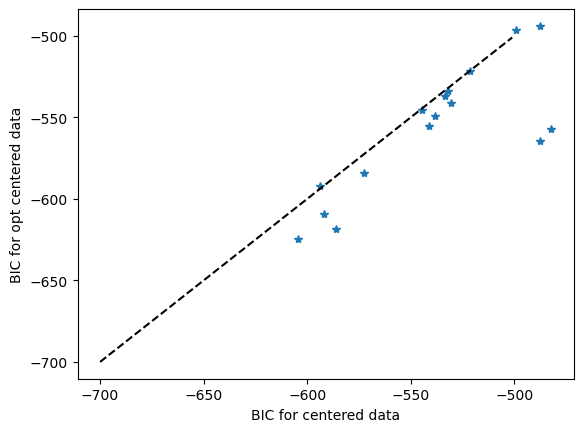

In [50]:
plt.plot(bics, opt_bics, '*')
plt.plot(np.arange(-700, -500), np.arange(-700, -500), 'k--')
plt.xlabel('BIC for centered data')
plt.ylabel('BIC for opt centered data')

Text(0, 0.5, '$\\Delta$ BIC [nats]')

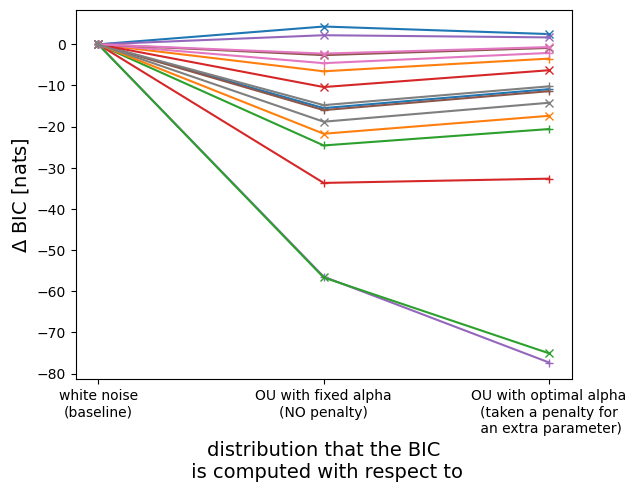

In [91]:
bic_changes = np.array([np.array(bics), np.array(diffsA_bics) ,np.array(opt_bics)]) - np.array(bics)
for k,bic_change in enumerate(bic_changes.T):
    plt.plot(bic_change, '-'+symbols[k//8], color=colors[k%8])
plt.xticks([0, 1, 2], ['white noise\n(baseline)', 'OU with fixed alpha\n(NO penalty)', 'OU with optimal alpha\n(taken a penalty for\n an extra parameter)'])
plt.xlabel('distribution that the BIC\n is computed with respect to', fontsize=14)
plt.ylabel(r'$\Delta$ BIC [nats]', fontsize=14)